## A - Data Import, resampling  and merging

(1) Data losses

In [23]:
import pandas as pd
import datetime as dt

df = pd.read_csv("../../data/Avtice-losses.csv", header = 1, parse_dates = ["Zeitstempel"])
df["Zeitstempel"] = df["Zeitstempel"] - dt.timedelta(minutes=15)
df = df.groupby("Zeitstempel", as_index=False).kWh.mean()
df = df.resample("H", on = "Zeitstempel").sum().reset_index()
data_loss = df
data_loss.set_index("Zeitstempel").index.duplicated().sum()

0

In [24]:
data_loss

,Zeitstempel,kWh
0,2019-01-01 00:00:00,139525.003695
1,2019-01-01 01:00:00,129716.036003
2,2019-01-01 02:00:00,133398.074458
3,2019-01-01 03:00:00,135133.851731
4,2019-01-01 04:00:00,131699.424059
...,...,...
26299,2021-12-31 19:00:00,171707.317615
26300,2021-12-31 20:00:00,159462.903412
26301,2021-12-31 21:00:00,155109.519730
26302,2021-12-31 22:00:00,171370.276941


(2) Renewable Generation

In [6]:
data_renewable_generation = pd.read_csv("../../data/Forecast-renewable-generation.csv", header = 0, parse_dates = ["datetime"])
data_renewable_generation = data_renewable_generation.groupby("datetime", as_index=False)[[col for col in data_renewable_generation.columns]].mean()
#data_renewable_generation

(3) NTC

In [7]:
data_NTC = pd.read_csv("../../data/NTC.csv", header = 0, parse_dates = ["datetime"])
data_NTC = data_NTC.groupby("datetime", as_index=False)[[col for col in data_NTC.columns]].mean()
#data_NTC

(4) Temperatures

In [8]:
df = pd.read_csv("../../data/Forecast-temperature_new.csv", header = 0)

df['datetime'] = pd.to_datetime(df['datetime'])
start_time = '2019-01-01 01:00'
end_time = '2021-12-31 23:00'
hourly_range = pd.date_range(start=start_time, end=end_time, freq='H')
df_resampled = pd.DataFrame({'datetime': hourly_range})
df_resampled = df_resampled.merge(df, on="datetime", how='left')
df_resampled.interpolate(inplace=True, fill_value='extrapolate')
data_temperatures = df_resampled
#data_temperatures

(5) Joins

In [36]:
data = data_temperatures.set_index("datetime")
data = data.join(data_renewable_generation.set_index("datetime"))
data = data.join(data_NTC.set_index("datetime"))
#data = data.join(data_loss.set_index("Zeitstempel"))

(6) Add Fourier-based features to describe periodicity 

In [37]:
from statsmodels.tsa.deterministic import CalendarFourier, TimeTrend
from statsmodels.tsa.stattools import pacf

In [38]:
cal_fourier_gen = CalendarFourier("D", 12)
fourier_data_daily = cal_fourier_gen.in_sample(data.index)
#fourier_data_daily

In [39]:
cal_fourier_gen_ = CalendarFourier("Y", 6)
fourier_data_yearly = cal_fourier_gen_.in_sample(data.index)
#fourier_data_yearly

In [40]:
trend_gen = TimeTrend(False, 1)
trend = trend_gen.in_sample(data.index)
#trend

In [41]:
n_shift = [1,2,3,4,5]
data_shift = pd.DataFrame()
for s in n_shift:
    data_shift[f"kWh_{s}"] = data_loss["kWh"].shift(s)
data_shift

,kWh_1,kWh_2,kWh_3,kWh_4,kWh_5
0,NaN,NaN,NaN,NaN,NaN
1,139525.003695,NaN,NaN,NaN,NaN
2,129716.036003,139525.003695,NaN,NaN,NaN
3,133398.074458,129716.036003,139525.003695,NaN,NaN
4,135133.851731,133398.074458,129716.036003,139525.003695,NaN
...,...,...,...,...,...
26299,152159.763051,162995.636188,188541.866015,176617.952629,167343.565308
26300,171707.317615,152159.763051,162995.636188,188541.866015,176617.952629
26301,159462.903412,171707.317615,152159.763051,162995.636188,188541.866015
26302,155109.519730,159462.903412,171707.317615,152159.763051,162995.636188


In [42]:
data_new = data.join([fourier_data_yearly, fourier_data_daily, trend])
#data_new

In [34]:
data_new

,temperature_fore_ch,temperature_fore_fr,temperature_fore_de,temperature_fore_it,solar_fore_de [MW],solar_fore_it [MW],wind_fore_de [MW],wind_fore_it [MW],CH_AT,CH_DE,...,"cos(8,freq=D)","sin(9,freq=D)","cos(9,freq=D)","sin(10,freq=D)","cos(10,freq=D)","sin(11,freq=D)","cos(11,freq=D)","sin(12,freq=D)","cos(12,freq=D)",trend
2019-01-01 01:00:00,4.1067,5.972900,7.426800,4.028100,0.0,0.0,23052.3310,4596.5916,700.0,4000.0,...,-0.5,7.071068e-01,-7.071068e-01,0.500000,-8.660254e-01,0.258819,-0.965926,1.224647e-16,-1.0,1.0
2019-01-01 02:00:00,3.7155,5.900717,7.246083,3.811433,0.0,0.0,24969.9701,4478.5564,700.0,4000.0,...,-0.5,-1.000000e+00,-1.836970e-16,-0.866025,5.000000e-01,-0.500000,0.866025,-2.449294e-16,1.0,2.0
2019-01-01 03:00:00,3.3243,5.828533,7.065367,3.594767,0.0,0.0,27082.9626,4323.3712,700.0,4000.0,...,1.0,7.071068e-01,7.071068e-01,1.000000,3.061617e-16,0.707107,-0.707107,3.673940e-16,-1.0,3.0
2019-01-01 04:00:00,2.9331,5.756350,6.884650,3.378100,0.0,0.0,26890.9717,4231.8283,700.0,4000.0,...,-0.5,3.673940e-16,-1.000000e+00,-0.866025,-5.000000e-01,-0.866025,0.500000,-4.898587e-16,1.0,4.0
2019-01-01 05:00:00,2.5419,5.684167,6.703933,3.161433,0.0,0.0,27740.1555,4266.3082,700.0,4000.0,...,-0.5,-7.071068e-01,7.071068e-01,0.500000,8.660254e-01,0.965926,-0.258819,6.123234e-16,-1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,8.5300,9.960000,10.790000,9.590000,0.0,0.0,36997.7200,1108.4000,1200.0,4000.0,...,-0.5,7.071068e-01,7.071068e-01,-0.500000,8.660254e-01,-0.965926,-0.258819,5.879543e-15,-1.0,26300.0
2021-12-31 20:00:00,8.0000,9.400000,10.630000,9.110000,0.0,0.0,35666.9300,1077.9700,1200.0,4000.0,...,-0.5,-1.715743e-15,-1.000000e+00,0.866025,-5.000000e-01,0.866025,0.500000,-2.449294e-15,1.0,26301.0
2021-12-31 21:00:00,7.5000,8.880000,10.510000,8.670000,0.0,0.0,34383.8800,1048.2800,1200.0,4000.0,...,1.0,-7.071068e-01,7.071068e-01,-1.000000,-3.919489e-15,-0.707107,-0.707107,-9.809554e-16,-1.0,26302.0
2021-12-31 22:00:00,6.9700,8.510000,10.320000,8.140000,0.0,0.0,33075.2500,1078.7800,1200.0,4000.0,...,-0.5,1.000000e+00,7.349738e-15,0.866025,5.000000e-01,0.500000,0.866025,-9.799650e-15,1.0,26303.0


(7) Join with the losses

In [43]:
data = data_new.join(data_loss.set_index("Zeitstempel"))

## B - Fully Connected ANN

In [44]:
import numpy as np
import tensorflow as tf
import sklearn

2023-09-16 08:01:59.715073: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-16 08:01:59.739383: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-16 08:01:59.740901: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 08:02:00.405592: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [47]:
X = data[[col for col in data.columns if col != "kWh"]]

    
    
y = data["kWh"].shift(-1)


filter_na = y.notna()
X = X[filter_na]
y = y[filter_na]

X = X.to_numpy()
y = np.expand_dims(y.to_numpy(), axis=1)

filt = np.array([not any(x) for x in np.isnan(X)])
X = X[filt]
y = y[filt]

In [48]:
print(X)

[[ 4.10670000e+00  5.97290000e+00  7.42680000e+00 ...  1.22464680e-16
  -1.00000000e+00  1.00000000e+00]
 [ 3.71550000e+00  5.90071667e+00  7.24608333e+00 ... -2.44929360e-16
   1.00000000e+00  2.00000000e+00]
 [ 3.32430000e+00  5.82853333e+00  7.06536667e+00 ...  3.67394040e-16
  -1.00000000e+00  3.00000000e+00]
 ...
 [ 8.00000000e+00  9.40000000e+00  1.06300000e+01 ... -2.44929360e-15
   1.00000000e+00  2.63010000e+04]
 [ 7.50000000e+00  8.88000000e+00  1.05100000e+01 ... -9.80955401e-16
  -1.00000000e+00  2.63020000e+04]
 [ 6.97000000e+00  8.51000000e+00  1.03200000e+01 ... -9.79965032e-15
   1.00000000e+00  2.63030000e+04]]


In [49]:
print(y)

[[133398.074458]
 [135133.851731]
 [131699.424059]
 ...
 [155109.51973 ]
 [171370.276941]
 [146054.790821]]


(1) Splitting the dataset into the Training set and Test set

In [52]:
#from sklearn.model_selection import train_test_splitANN
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.2, random_state = 0)

In [53]:
X_test

array([[ 1.65610667e+01,  1.78887000e+01,  1.61576667e+01, ...,
         3.67394040e-16, -1.00000000e+00,  1.47150000e+04],
       [ 1.81100000e+00,  2.93266667e+00, -1.52166667e-01, ...,
        -1.47081412e-15, -1.00000000e+00,  1.78250000e+04],
       [ 1.42678667e+01,  1.68833000e+01,  1.38056333e+01, ...,
        -1.22464680e-15,  1.00000000e+00,  6.08200000e+03],
       ...,
       [-5.61633333e-01,  6.16033333e-01,  1.61510000e+00, ...,
        -7.34788079e-16,  1.00000000e+00,  1.76220000e+04],
       [ 2.28600000e+01,  2.27200000e+01,  2.09600000e+01, ...,
        -1.22464680e-15,  1.00000000e+00,  2.29780000e+04],
       [ 5.37961667e+00,  9.23038333e+00,  6.55101667e+00, ...,
        -2.20436424e-15,  1.00000000e+00,  9.93000000e+03]])

In [54]:
y_train

array([[105881.914572],
       [168219.084846],
       [113622.840041],
       ...,
       [157128.98015 ],
       [ 59554.920753],
       [ 47244.277699]])

(2) Feature scaling

In [55]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)
y_test = sc_y.transform(y_test)


In [56]:
X_test

array([[ 0.77283313,  0.66425291,  0.75742313, ...,  0.15692658,
        -0.99653822,  0.20797267],
       [-1.19063449, -1.54284049, -1.50318842, ..., -0.33775373,
        -0.99653822,  0.61707643],
       [ 0.46757187,  0.51588391,  0.43142141, ..., -0.27150762,
         1.0034738 , -0.927652  ],
       ...,
       [-1.50646959, -1.88471096, -1.25823782, ..., -0.13968171,
         1.0034738 ,  0.59037287],
       [ 1.61132098,  1.37721805,  1.42304674, ..., -0.27150762,
         1.0034738 ,  1.29492584],
       [-0.71559506, -0.61347315, -0.57409899, ..., -0.53515944,
         1.0034738 , -0.42146832]])

(3) Build the model

In [57]:
# a - Initializing the ANN
ann = tf.keras.models.Sequential()
# b - Adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
# c - Adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
# d - Adding the output layer
ann.add(tf.keras.layers.Dense(units=1))

2023-09-16 08:04:33.581881: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


(4) Training the ANN

In [58]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [59]:
# Compiling the ANN
ann.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])

# Training the ANN on the Training set
ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100
658/658 [==============================] - 1s 830us/step - loss: 0.5014 - mse: 0.5014
Epoch 2/100
658/658 [==============================] - 1s 814us/step - loss: 0.3960 - mse: 0.3960
Epoch 3/100
658/658 [==============================] - 1s 801us/step - loss: 0.3657 - mse: 0.3657
Epoch 4/100
658/658 [==============================] - 1s 781us/step - loss: 0.3445 - mse: 0.3445
Epoch 5/100
658/658 [==============================] - 1s 791us/step - loss: 0.3292 - mse: 0.3292
Epoch 6/100
658/658 [==============================] - 1s 803us/step - loss: 0.3154 - mse: 0.3154
Epoch 7/100
658/658 [==============================] - 1s 800us/step - loss: 0.3038 - mse: 0.3038
Epoch 8/100
658/658 [==============================] - 1s 794us/step - loss: 0.2917 - mse: 0.2917
Epoch 9/100
658/658 [==============================] - 1s 795us/step - loss: 0.2801 - mse: 0.2801
Epoch 10/100
658/658 [==============================] - 1s 793us/step - loss: 0.2734 - mse: 0.2734
Epoch 11/100
658/65

658/658 [==============================] - 1s 791us/step - loss: 0.1104 - mse: 0.1104
Epoch 84/100
658/658 [==============================] - 1s 787us/step - loss: 0.1096 - mse: 0.1096
Epoch 85/100
658/658 [==============================] - 1s 789us/step - loss: 0.1091 - mse: 0.1091
Epoch 86/100
658/658 [==============================] - 1s 794us/step - loss: 0.1084 - mse: 0.1084
Epoch 87/100
658/658 [==============================] - 1s 789us/step - loss: 0.1091 - mse: 0.1091
Epoch 88/100
658/658 [==============================] - 1s 790us/step - loss: 0.1086 - mse: 0.1086
Epoch 89/100
658/658 [==============================] - 1s 787us/step - loss: 0.1071 - mse: 0.1071
Epoch 90/100
658/658 [==============================] - 1s 792us/step - loss: 0.1071 - mse: 0.1071
Epoch 91/100
658/658 [==============================] - 1s 795us/step - loss: 0.1076 - mse: 0.1076
Epoch 92/100
658/658 [==============================] - 1s 792us/step - loss: 0.1058 - mse: 0.1058
Epoch 93/100
658/658 [=

In [100]:
ann

(5) Single point prediction

In [181]:
X_train

array([[ 2.00738619,  1.46323412,  1.52897788, ...,  0.17341794,
        -1.19692278, -0.35557691],
       [-0.84097718, -0.9791716 , -1.41255476, ..., -1.36289471,
        -0.2310321 ,  1.06409652],
       [-0.50770855, -0.25638005, -0.99385852, ..., -1.07224097,
         2.26218986,  0.49622714],
       ...,
       [-1.15944306, -0.90304749, -0.99061931, ..., -1.07224097,
         0.39959074,  0.49622714],
       [-1.30163483, -1.19021247, -1.18515217, ..., -1.07224097,
         0.39959074,  1.06409652],
       [ 0.09471896,  0.2177207 ,  0.88420334, ..., -1.07224097,
        -1.02928886,  0.49622714]])

In [60]:
print(ann.predict(X_test))

165/165 [==============================] - 0s 642us/step
[[-0.56150746]
 [ 2.1033058 ]
 [-0.1715426 ]
 ...
 [ 0.21456456]
 [-1.4038761 ]
 [-0.05044996]]


In [172]:
print(y_test)

[[ 68100.875419]
 [ 84321.367955]
 [ 75303.191799]
 ...
 [ 90202.164123]
 [138678.206819]
 [ 52018.748047]]


In [173]:
ann_score = ann.evaluate(X_test, y_test, verbose = 1)
ann_score

165/165 [==============================] - 0s 791us/step - loss: 604413120.0000 - mse: 604413120.0000


[604413120.0, 604413120.0]

In [61]:
import matplotlib.pyplot as plt

165/165 [==============================] - 0s 636us/step


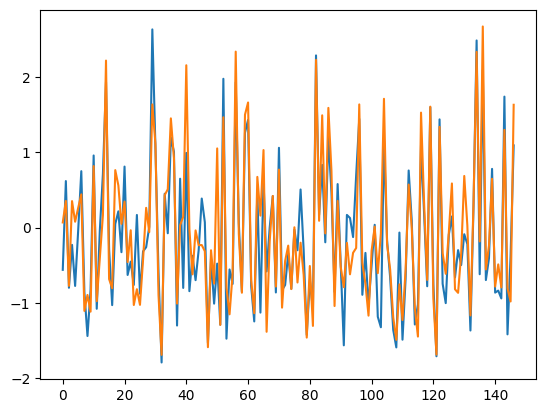

In [62]:
plt.plot(ann.predict(X_test)[::36])
plt.plot(y_test[::36])

In [188]:
sc_y.inverse_transform(y_test)

array([[ 68100.875419],
       [ 84321.367955],
       [ 75303.191799],
       ...,
       [ 90202.164123],
       [138678.206819],
       [ 52018.748047]])

165/165 [==============================] - 0s 645us/step


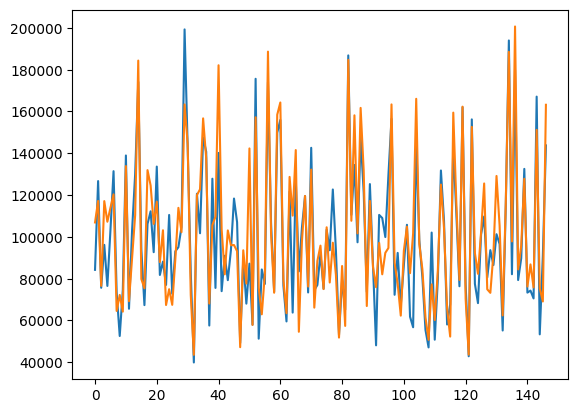

In [63]:
plt.plot(sc_y.inverse_transform(ann.predict(X_test))[::36])
plt.plot(sc_y.inverse_transform(y_test)[::36])